# Config

In [1]:
import os
data_dir = '/kaggle/input/cbc-data'

In [2]:
# Hyper-parameter
VERSION = 1
DEBUG = False
EDA = True

CENTRAL_BANK = ['ECB', 'Riksbank'] # Possible values: 'Riksbank', 'Finlands Bank', 'ECB'
TRAIN_BANKS = ['ECB', 'Riksbank']

FROM_DATE = '2002-04-02'
TO_DATE = '2023-04-01'
TRAIN_WINDOW = 12 # year
TEST_WINDOW = 4 # year
LAST_TRAIN_YEAR = 2023 - TRAIN_WINDOW - TEST_WINDOW


# Topic keywords
TOPIC_FILTER = True
N_TOPICS = 6
TOPIC_KEYWORD = ['monetary', 'policy', 'rate', 'inflation', 'exchange', 'payment', 'stability', 'objective']

# Undersampling
UNDERSAMPLING = True

# Period to predict and periods used as features
PREDICT_PERIOD = 90
PAST_PERIOD = [90, 180]

PREDICT_PERIOD_VARIABLE = f'predict_rate_change_{PREDICT_PERIOD}D'
PAST_PERIOD_VARIABLE = [f'past_rate_change_{d}D' for d in PAST_PERIOD]

# Classes
CLASS = ['Decrease', 'Increase', 'Same']

print("Past rate change features: ", PAST_PERIOD_VARIABLE)
print("Target: ", PREDICT_PERIOD_VARIABLE)

Past rate change features:  ['past_rate_change_90D', 'past_rate_change_180D']
Target:  predict_rate_change_90D


In [3]:
# Model parameter
PRETRAINED_MODEL = 'microsoft/deberta-v3-base'

MAX_LEN = 128

MODEL_NAME = f'{PRETRAINED_MODEL.split("/",1)[1]}_v{VERSION}'
LOAD_MODEL_FROM = os.path.join(data_dir, MODEL_NAME)
print(MODEL_NAME)
print(LOAD_MODEL_FROM)

LOAD_LDA_FROM = "/kaggle/input/cbc-lda"

deberta-v3-base_v1
/kaggle/input/cbc-data/deberta-v3-base_v1


In [4]:
# Import useful libraries 
import pandas as pd
import numpy as np
import re
import random
import time
import pickle
from ast import literal_eval
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10,4)})

In [5]:
# Set up device: TPU or GPU
from transformers import *
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('TPU strategy')
except:
    if len(tf.config.list_physical_devices('GPU')) >= 2:
        strategy = tf.distribute.MirroredStrategy()
        print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))
    else:
        strategy = tf.distribute.get_strategy()
        print('single strategy')
        
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

/opt/conda/lib/python3.7/site-packages/transformers/generation_utils.py:27: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/generation_tf_utils.py:27: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/generation_flax_utils.py:27: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  FutureWarning,
Loading custom CUDA kernels...


DEVICES AVAILABLE: 2
Mixed precision enabled


# Get data

## Speeches

### Riksbank, Finlands Bank

In [6]:
# Helper function to get corpus dataset
def get_corpus(data_dir, from_date=FROM_DATE, sep=","):
    data = pd.read_csv(data_dir, sep=sep)
    data['date'] = pd.to_datetime(data['date'])
    return data[data['date'] >= from_date]

corpus_df = get_corpus(os.path.join(data_dir,'all_corpus.csv'))
corpus_df['article'] = corpus_df['article'].str.split("\n")
corpus_df['article_len'] = corpus_df['article'].str.len()

print("df shape: ", corpus_df.shape)
corpus_df.head()

df shape:  (713, 8)


,bank,policy_rate_control,id,date,speaker,speaker_title,article,article_len
0,Riksbank,Riksbank,r23032023erlg,2023-03-23,Erik Thedéen Governor,Governor,[Mr Thedéen began his speech by commenting on...,8
1,Riksbank,Riksbank,r14032023erwt,2023-03-14,Erik Thedéen Governor,Governor,[Governor Erik Thedéen began the hearing by s...,9
2,Riksbank,Riksbank,r14032023aiek,2023-03-14,Aino Bunge Deputy Governor,Deputy Governor,[Governor Erik Thedéen began the hearing by s...,9
3,Riksbank,Riksbank,r09032023aibz,2023-03-09,Aino Bunge Deputy Governor,Deputy Governor,[“It is a tough situation for many people when...,4
4,Riksbank,Riksbank,r31012023erds,2023-01-31,Erik Thedéen Governor,Governor,[Erik Thedéen emphasised that significant vul...,3


### ECB

In [7]:
# Get speeches from file downloaded from ECB website
ecb_corpus_df = get_corpus(os.path.join(data_dir,'all_ECB_speeches.csv'), sep="|")
ecb_corpus_df['speaker_title'] = ecb_corpus_df['subtitle'].str.split(',').str[1]
ecb_corpus_df['article_len'] = ecb_corpus_df['contents'].str.len()
ecb_corpus_df = ecb_corpus_df[ecb_corpus_df['article_len'] > 100]
ecb_corpus_df['id'] = 'ecb' + ecb_corpus_df['date'].dt.strftime('%m%d%Y') + ecb_corpus_df['speakers'].str[:2].str.lower() + ecb_corpus_df['article_len'].astype(str)
ecb_corpus_df['bank'] = "ECB"
ecb_corpus_df['policy_rate_control'] = "ECB"
ecb_corpus_df['article'] = ecb_corpus_df['contents'].apply(lambda s: re.split(r'\s{2,}',s))
ecb_corpus_df = ecb_corpus_df[['bank', 'policy_rate_control', 'id', 'date', 'speakers', 'speaker_title', 'article']]
ecb_corpus_df.rename(columns={'speakers': 'speaker'}, inplace=True)

print("df shape: ", ecb_corpus_df.shape)
print("Number of unique ids: ", len(ecb_corpus_df['id'].unique()))
ecb_corpus_df.head()

df shape:  (2272, 7)
Number of unique ids:  2272


,bank,policy_rate_control,id,date,speaker,speaker_title,article
1,ECB,ECB,ecb03272023is33406.0,2023-03-27,Isabel Schnabel,Member of the Executive Board of the ECB,"[, SPEECH, Back to normal? Balance sheet size ..."
2,ECB,ECB,ecb03272023fr18839.0,2023-03-27,Frank Elderson,Member of the Executive Board of the ECB and ...,"[, SPEECH, Urgent and vitally important: 2023 ..."
5,ECB,ECB,ecb03222023fa37874.0,2023-03-22,Fabio Panetta,Member of the Executive Board of the ECB,"[, SPEECH, Everything everywhere all at once: ..."
7,ECB,ECB,ecb03222023ch19907.0,2023-03-22,Christine Lagarde,President of the ECB,"[, SPEECH, The path ahead, Speech by Christine..."
8,ECB,ECB,ecb03202023ch8577.0,2023-03-20,Christine Lagarde,President of the ECB,"[, SPEECH, Hearing of the Committee on Economi..."


### All speeches

In [8]:
# Join speech tables
full_corpus_df = pd.concat([corpus_df, ecb_corpus_df])
full_corpus_df = full_corpus_df[full_corpus_df['bank'].isin(CENTRAL_BANK)]
full_corpus_df.shape

(2797, 8)

In [9]:
# Convert long article to smaller paragraph
full_corpus_df = full_corpus_df.explode('article')
full_corpus_df['article_len'] = full_corpus_df['article'].str.strip().str.split().apply(len)
full_corpus_df = full_corpus_df[full_corpus_df['article_len'] > 10]

print("df shape: ", full_corpus_df.shape)
full_corpus_df.head()

df shape:  (73419, 8)


,bank,policy_rate_control,id,date,speaker,speaker_title,article,article_len
0,Riksbank,Riksbank,r23032023erlg,2023-03-23,Erik Thedéen Governor,Governor,Mr Thedéen began his speech by commenting on ...,37
0,Riksbank,Riksbank,r23032023erlg,2023-03-23,Erik Thedéen Governor,Governor,“Although the situation has become a little ca...,110
0,Riksbank,Riksbank,r23032023erlg,2023-03-23,Erik Thedéen Governor,Governor,He went on to note that the inflation figures ...,63
0,Riksbank,Riksbank,r23032023erlg,2023-03-23,Erik Thedéen Governor,Governor,“One important reason for this is the reforms ...,87
0,Riksbank,Riksbank,r23032023erlg,2023-03-23,Erik Thedéen Governor,Governor,Mr Thedéen then highlighted the danger of inf...,105


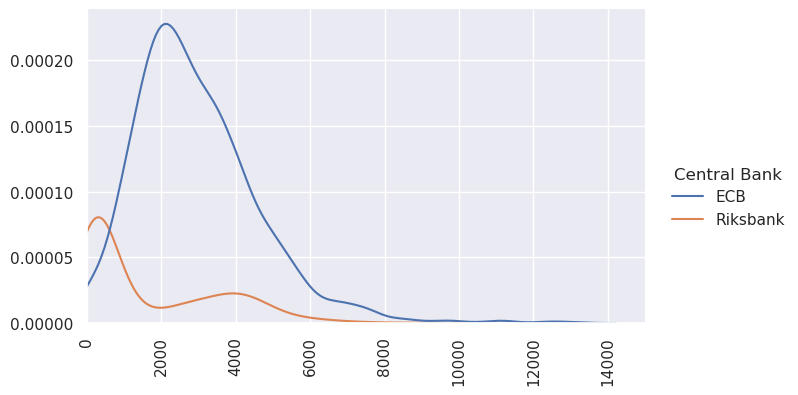

In [10]:
# Article length distribution
if EDA:
    data = full_corpus_df.groupby([full_corpus_df['bank'], full_corpus_df['id']]).agg({'article_len': 'sum'}).reset_index()
    data.rename(columns={"bank": "Central Bank"}, inplace=True)
    sns.displot(data, x="article_len", hue="Central Bank", kind="kde", height=4, aspect=7/4)
    plt.xticks(rotation=90)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.xlim(0)
    plt.show()

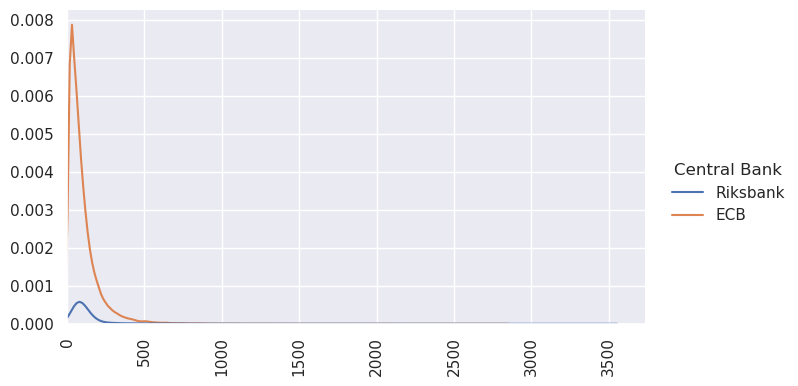

In [11]:
# Paragraph length distribution
if EDA:
    data = full_corpus_df[['bank', 'article_len']].copy()
    data.rename(columns={"bank": "Central Bank"}, inplace=True)
    sns.displot(data, x="article_len", hue="Central Bank", kind="kde", height=4, aspect=7/4)
    plt.xticks(rotation=90)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.xlim(0)
    plt.show()

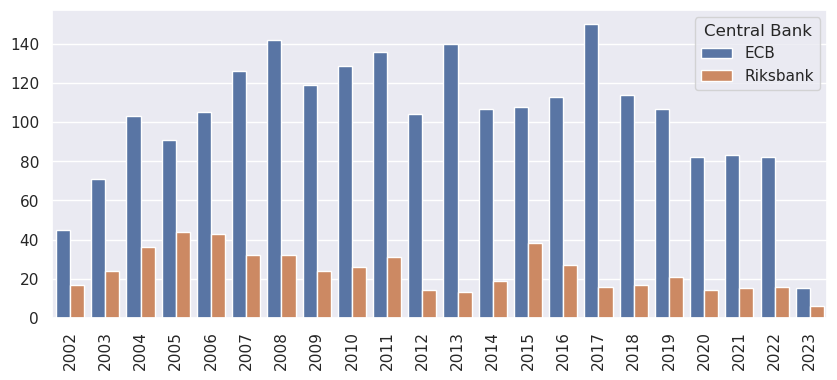

In [12]:
# Number of article per year
if EDA:
    data = full_corpus_df.groupby([full_corpus_df['bank'], full_corpus_df['date'].dt.to_period("Y")]).agg({'id': 'nunique'}).reset_index()
    sns.barplot(data, x='date', y='id', hue='bank')
    plt.xticks(rotation=90)
    plt.legend(title='Central Bank', loc='upper right')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()

## Policy rate

### Riks bank

In [13]:
# Helper function to get and process policy rate csv files
def get_policy_rate(data_dir, skiprows=None,
                    policy_rate_control = "Riksbank",
                    date_col = "Period", format_date = "%d/%m/%Y",
                    value_col = "Value", 
                    from_date=FROM_DATE, to_date=TO_DATE,
                    convert_value_col=False,
                    sep=","):
    data = pd.read_csv(data_dir, sep=sep, skiprows=skiprows)
    data['policy_rate_control'] = policy_rate_control
    data[date_col] = pd.to_datetime(data[date_col], format=format_date)
    data = data[["policy_rate_control", date_col, value_col]]
    data.columns = ["policy_rate_control", "date", "policy_rate"]
    data = data[data['date'] >= from_date]
    
    # Fill rate when data is not available
    date_df = pd.DataFrame({'date': pd.date_range(start=from_date, end=to_date)})
    data = date_df.merge(data, on='date', how='left')
    data = data.fillna(method='ffill')
    
    # If rate format is not appropriate, fix the column
    if convert_value_col:
        data['policy_rate'] = data['policy_rate'].str.replace(",",".").astype(float)
    
    # Create past rate change and future rate change columns
    data[PREDICT_PERIOD_VARIABLE] = data['policy_rate'].shift(-PREDICT_PERIOD) - data['policy_rate']
    for i in range(len(PAST_PERIOD_VARIABLE)):
        data[PAST_PERIOD_VARIABLE[i]] = data['policy_rate'] - data['policy_rate'].shift(PAST_PERIOD[i])
    
    for col in (PAST_PERIOD_VARIABLE + [PREDICT_PERIOD_VARIABLE]):
        conditions  = [data[col] > 0, data[col] == 0, data[col] < 0]
        choices     = ['Increase', 'Same', 'Decrease']
        data[f'{col}_class'] = np.select(conditions, choices, default=np.nan)
    return data

riks_rate_df = get_policy_rate(
    data_dir = os.path.join(data_dir,'riksbank_policy_rate.csv'),
    convert_value_col = True,
    sep=";"
)

print("df shape: ", riks_rate_df.shape)
riks_rate_df.dropna().head()

df shape:  (7670, 9)


,date,policy_rate_control,policy_rate,predict_rate_change_90D,past_rate_change_90D,past_rate_change_180D,past_rate_change_90D_class,past_rate_change_180D_class,predict_rate_change_90D_class
180,2002-09-29,Riksbank,4.25,-0.5,0.0,0.25,Same,Increase,Decrease
181,2002-09-30,Riksbank,4.25,-0.5,0.0,0.25,Same,Increase,Decrease
182,2002-10-01,Riksbank,4.25,-0.5,0.0,0.25,Same,Increase,Decrease
183,2002-10-02,Riksbank,4.25,-0.5,0.0,0.25,Same,Increase,Decrease
184,2002-10-03,Riksbank,4.25,-0.5,0.0,0.25,Same,Increase,Decrease


### ECB official interest rate

In [14]:
# Get data for ECB
ecb_rate_df = get_policy_rate(
    data_dir = os.path.join(data_dir,'ecb_interest_rate.csv'),
    skiprows = [0,1,3,4],
    policy_rate_control = "ECB",
    date_col = "Unnamed: 0", format_date = "%Y-%m-%d",
    value_col = "Daily, ECB Deposit facility - date of changes (raw data), Level",
)

print(ecb_rate_df.shape)
ecb_rate_df.dropna().head()

(7670, 9)


,date,policy_rate_control,policy_rate,predict_rate_change_90D,past_rate_change_90D,past_rate_change_180D,past_rate_change_90D_class,past_rate_change_180D_class,predict_rate_change_90D_class
180,2002-09-29,ECB,2.25,-0.5,0.0,0.0,Same,Same,Decrease
181,2002-09-30,ECB,2.25,-0.5,0.0,0.0,Same,Same,Decrease
182,2002-10-01,ECB,2.25,-0.5,0.0,0.0,Same,Same,Decrease
183,2002-10-02,ECB,2.25,-0.5,0.0,0.0,Same,Same,Decrease
184,2002-10-03,ECB,2.25,-0.5,0.0,0.0,Same,Same,Decrease


### All policy rate

In [15]:
# Join all policy rate tables
full_rate_df = pd.concat([riks_rate_df, ecb_rate_df])

print("df shape: ", full_rate_df.shape)
full_rate_df.dropna().head()

df shape:  (15340, 9)


,date,policy_rate_control,policy_rate,predict_rate_change_90D,past_rate_change_90D,past_rate_change_180D,past_rate_change_90D_class,past_rate_change_180D_class,predict_rate_change_90D_class
180,2002-09-29,Riksbank,4.25,-0.5,0.0,0.25,Same,Increase,Decrease
181,2002-09-30,Riksbank,4.25,-0.5,0.0,0.25,Same,Increase,Decrease
182,2002-10-01,Riksbank,4.25,-0.5,0.0,0.25,Same,Increase,Decrease
183,2002-10-02,Riksbank,4.25,-0.5,0.0,0.25,Same,Increase,Decrease
184,2002-10-03,Riksbank,4.25,-0.5,0.0,0.25,Same,Increase,Decrease


In [16]:
# Descriptive statistics for policy rate
def quantile(n):
    def quantile_(x):
        return x.quantile(n/100)
    quantile_.__name__ = f'{n}%'
    return quantile_


full_rate_describe_df = full_rate_df.groupby("policy_rate_control").agg({'policy_rate': ['min', quantile(25), quantile(50), quantile(75), 'max'],
                                                 'date': ['min', 'max']
                                                })
full_rate_describe_df.columns = ['min', 'Q25', 'Q50', 'Q75', 'max', 'min date', 'max date']
full_rate_describe_df.index.name = 'Central Bank'
full_rate_describe_df.reset_index(inplace=True)
full_rate_describe_df.to_csv('/kaggle/working/eda_policy_rate_describe.csv', index=False)
full_rate_describe_df

,Central Bank,min,Q25,Q50,Q75,max,min date,max date
0,ECB,-0.5,-0.4,0.25,1.0,3.25,2002-04-02,2023-04-01
1,Riksbank,-0.5,0.0,1.00,2.0,4.75,2002-04-02,2023-04-01


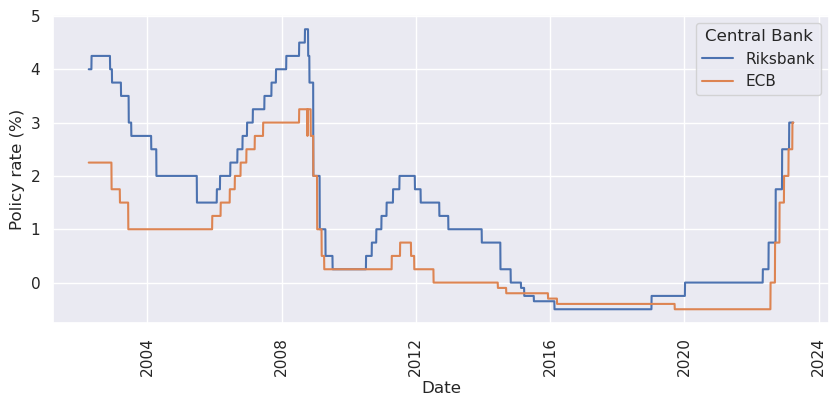

In [17]:
# Compare policy rate
if EDA: 
    sns.lineplot(data=full_rate_df, x='date', y='policy_rate', hue='policy_rate_control')
    plt.legend(title='Central Bank', loc='upper right')
    plt.ylabel("Policy rate (%)")
    plt.xlabel("Date")
    plt.xticks(rotation=90)
    plt.show()

# Prepare dataset

In [18]:
# Combine speeches and policy rate tables
full_df = full_corpus_df.merge(full_rate_df, on=['date','policy_rate_control'], how='left')
full_df['year'] = full_df['date'].dt.year  
full_df = full_df.dropna()

print("df shape: ", full_df.shape)
full_df.head()

df shape:  (71356, 16)


,bank,policy_rate_control,id,date,speaker,speaker_title,article,article_len,policy_rate,predict_rate_change_90D,past_rate_change_90D,past_rate_change_180D,past_rate_change_90D_class,past_rate_change_180D_class,predict_rate_change_90D_class,year
36,Riksbank,Riksbank,r14122022mait,2022-12-14,Martin Flodén Deputy Governor,Deputy Governor,"Mr Flodén noted that it is difficult, or perh...",53,2.5,0.5,1.75,2.25,Increase,Increase,Increase,2022
37,Riksbank,Riksbank,r14122022mait,2022-12-14,Martin Flodén Deputy Governor,Deputy Governor,The Riksbank’s purchases during the coronaviru...,87,2.5,0.5,1.75,2.25,Increase,Increase,Increase,2022
38,Riksbank,Riksbank,r14122022mait,2022-12-14,Martin Flodén Deputy Governor,Deputy Governor,Calculations indicate that the purchases of go...,122,2.5,0.5,1.75,2.25,Increase,Increase,Increase,2022
39,Riksbank,Riksbank,r09122022peor,2022-12-09,Per Jansson Deputy Governor,Deputy Governor,“A lot has changed in a year. Inflation has ri...,65,2.5,0.5,1.75,2.25,Increase,Increase,Increase,2022
40,Riksbank,Riksbank,r09122022peor,2022-12-09,Per Jansson Deputy Governor,Deputy Governor,"Today inflation in Sweden is 9.3 per cent, hig...",43,2.5,0.5,1.75,2.25,Increase,Increase,Increase,2022


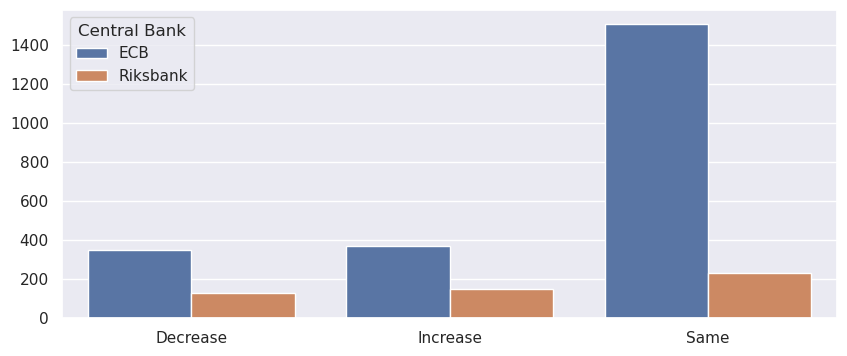

In [19]:
# Distribution of policy rate change
if EDA: 
    data = full_df.groupby(["bank","predict_rate_change_90D_class"]).agg({'id':'nunique'}).reset_index()
    sns.barplot(data, x='predict_rate_change_90D_class', y='id', hue='bank')
    plt.legend(title='Central Bank')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()

# Model pipeline

In [20]:
if DEBUG:
    beg_year = 2008
    train_ids = full_df[full_df['year'].between(beg_year, beg_year+TRAIN_WINDOW)].index.values
    test_ids = full_df[full_df['bank'] == 'Riksbank'][full_df['year'].between(beg_year+TRAIN_WINDOW+1, beg_year+TRAIN_WINDOW+TEST_WINDOW)].index.values
    
    # Extract data
    train_df, test_df = full_df.loc[train_ids], full_df.loc[test_ids]
    
    print("Train min year: ", np.min(train_df['year']))
    print("Train max year: ", np.max(train_df['year']))
    print("Test min year: ", np.min(test_df['year']))
    print("Test max year: ", np.max(test_df['year']))
    print("Train shape: ", train_df.shape)
    print("Test shape: ", test_df.shape)

## Filter bank

In [21]:
def filter_bank(dataset, banks=['Riksbank']):
    result = dataset[dataset['bank'].isin(banks)]
    return result

## LDA

In [22]:
import gensim
from pprint import pprint
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
from operator import itemgetter

# Helper functions
# Simple preprocess
def preprocess(article):
    result = gensim.utils.simple_preprocess(article, deacc=True) # lowercase, deaccent
    result = [w for w in result if w not in stop_words] # remove stop words
    result = [w.lemma_ for w in nlp(" ".join(result))] # lemmatize
    return result

In [23]:
# remake
def train_lda(train_df, filter_topic=True):
    # data for training model
    articles = train_df['article'].tolist()
    articles = [preprocess(s) for s in articles]
    id2word = gensim.corpora.Dictionary(articles)
    corpus = [id2word.doc2bow(s) for s in articles]
    
    # fit LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=N_TOPICS, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
    
    # Filter topics
    topic_dict = {}
    topic_list = lda_model.show_topics(num_topics=N_TOPICS, num_words=15,formatted=False)
    for i in range(len(topic_list)):
        temp_dict = {}
        for (key, value) in topic_list[i][1]:
            temp_dict[key] = value
        if not filter_topic: 
            topic_dict[i] = temp_dict
        else:
            if (set(temp_dict.keys()) & set(TOPIC_KEYWORD)):
                topic_dict[i] = temp_dict
    
    train_df['topic'] = [max(lda_model.get_document_topics(c), key=itemgetter(1))[0] for c in corpus]
    train_df = train_df[train_df['topic'].isin(topic_dict.keys())]
    
    return train_df, lda_model, topic_dict, id2word, corpus

def pred_lda(test_df, id2word, lda_model, topic_dict):
    # Helper function
    def get_topic(article):
        s = preprocess(article)
        corp = id2word.doc2bow(s)
        return max(lda_model.get_document_topics(corp), key=itemgetter(1))[0]
    
    test_df['topic'] = test_df['article'].apply(lambda s: get_topic(s))
    test_df = test_df[test_df['topic'].isin(topic_dict.keys())]
    
    return test_df
    

if DEBUG and TOPIC_FILTER:
    train_df, lda_model, topic_dict, id2word, corpus = train_lda(train_df)
    test_df = pred_lda(test_df, id2word, lda_model, topic_dict)
    
    print("Train shape: ", train_df.shape)
    print("Test shape: ", test_df.shape)
    print("Train topic: ", train_df.groupby('topic').id.count())
    print("Test topic: ", test_df.groupby('topic').id.count())
    pprint(topic_dict)

[(0,
  '0.044*"central" + 0.038*"bank" + 0.037*"european" + 0.016*"would" + '
  '0.014*"use" + 0.013*"state" + 0.013*"payment" + 0.013*"new" + '
  '0.013*"currency" + 0.012*"objective"'),
 (1,
  '0.050*"de" + 0.033*"la" + 0.018*"view" + 0.015*"que" + 0.015*"en" + '
  '0.013*"relate" + 0.012*"el" + 0.009*"although" + 0.009*"del" + '
  '0.009*"conduct"'),
 (2,
  '0.053*"monetary" + 0.048*"policy" + 0.041*"price" + 0.032*"economic" + '
  '0.031*"growth" + 0.029*"rate" + 0.028*"inflation" + 0.025*"term" + '
  '0.013*"interest" + 0.013*"long"'),
 (3,
  '0.054*"der" + 0.053*"die" + 0.032*"und" + 0.014*"zu" + 0.014*"den" + '
  '0.013*"fur" + 0.012*"eine" + 0.012*"auf" + 0.012*"von" + 0.011*"des"'),
 (4,
  '0.029*"stability" + 0.028*"financial" + 0.016*"ecb" + 0.014*"system" + '
  '0.014*"integration" + 0.012*"policy" + 0.012*"eu" + 0.010*"role" + '
  '0.010*"member" + 0.010*"need"'),
 (5,
  '0.045*"euro" + 0.030*"market" + 0.029*"area" + 0.021*"country" + '
  '0.008*"exchange" + 0.008*"proces

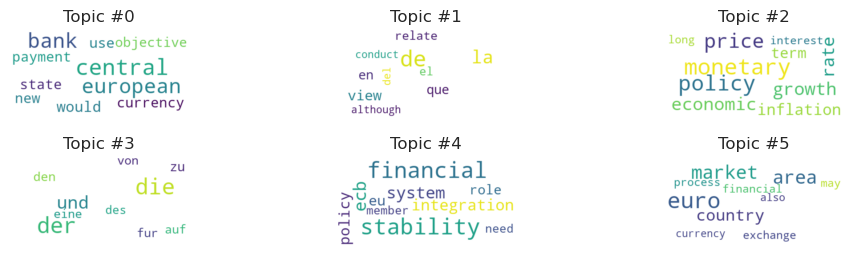

In [24]:
if EDA and TOPIC_FILTER:
    # Load model
    if os.path.exists(LOAD_LDA_FROM):
        id2word = pickle.load(open('/kaggle/input/cbc-lda/id2word.lda', 'rb'))
        corpus = pickle.load(open('/kaggle/input/cbc-lda/corpus.lda', 'rb'))
        lda_model = pickle.load(open('/kaggle/input/cbc-lda/lda_model.lda', 'rb'))
        topic_dict = pickle.load(open('/kaggle/input/cbc-lda/topic_dict.lda', 'rb'))
    else:
        train_df, lda_model, topic_dict, id2word, corpus = train_lda(full_df, filter_topic=False)
        pickle.dump(corpus, open('/kaggle/working/corpus.lda', 'wb'))
        pickle.dump(id2word, open('/kaggle/working/id2word.lda', 'wb'))
        pickle.dump(lda_model, open('/kaggle/working/lda_model.lda', 'wb'))
        pickle.dump(topic_dict, open('/kaggle/working/topic_dict.lda', 'wb'))
    
    pprint(lda_model.print_topics())
    
    # Word cloud
    from wordcloud import WordCloud

    plt.figure()
    j = int(np.ceil(N_TOPICS/2))
    for t in range(N_TOPICS):
        i=t+1
        wordcloud = WordCloud(max_font_size=50, max_words=10, background_color="white")
        wordcloud.generate_from_frequencies(frequencies=topic_dict[t])
        plt.subplot(j, j, i).set_title("Topic #" + str(t))
        plt.plot()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
    plt.tight_layout()
    plt.show()    

## Undersampling

In [25]:
# remake
def undersample(train_df, imbalanced_bank = ['ECB']):
    # Implement undersampling to make the train dataset more balanced
    increase_df = train_df[train_df['bank'].isin(imbalanced_bank)][train_df[f'{PREDICT_PERIOD_VARIABLE}_class'] == "Increase"]
    decrease_df = train_df[train_df['bank'].isin(imbalanced_bank)][train_df[f'{PREDICT_PERIOD_VARIABLE}_class'] == "Decrease"]
    same_df = train_df[train_df['bank'].isin(imbalanced_bank)][train_df[f'{PREDICT_PERIOD_VARIABLE}_class'] == "Same"]
    res_df = train_df[~train_df['bank'].isin(imbalanced_bank)]
    
    max_size = max(increase_df.shape[0], decrease_df.shape[0])
    same_df = same_df.sample(int(max_size))
    
    return shuffle(pd.concat([res_df, increase_df, decrease_df, same_df]))

if DEBUG:
    train_df= undersample(train_df, ['ECB'])
    print("Train shape: ", train_df.shape)
    print(train_df.groupby(f'{PREDICT_PERIOD_VARIABLE}_class').id.count())

    # Check if train_df is balanced
    data = train_df.groupby(f'{PREDICT_PERIOD_VARIABLE}_class').agg({'id': 'count'}).reset_index()
    sns.barplot(data, x=f'{PREDICT_PERIOD_VARIABLE}_class', y='id')
    plt.show()

## Neural network

In [26]:
# Check if we already have trained parameters
with strategy.scope():
    if os.path.exists(LOAD_MODEL_FROM):
        tokenizer = AutoTokenizer.from_pretrained(f'{LOAD_MODEL_FROM}')
        config = AutoConfig.from_pretrained(f'{LOAD_MODEL_FROM}/config.json')
        backbone = TFAutoModel.from_pretrained(f'{LOAD_MODEL_FROM}/tf_model.h5')
    else:
        tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
        config = AutoConfig.from_pretrained(PRETRAINED_MODEL, output_hidden_states=True)
        backbone = TFAutoModel.from_pretrained(PRETRAINED_MODEL, config=config)

def get_token(df):
    nrows = df.shape[0]
    input_ids = np.zeros((nrows, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((nrows, MAX_LEN), dtype='int32')
    
    for i in range(nrows):
        txt = df.iloc[i]['article']
        tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length', truncation=True)
        input_ids[i,] = tokens['input_ids']
        attention_mask[i,] = tokens['attention_mask']
    return input_ids, attention_mask

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-v3-base/snapshots/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/config.json
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.27.3",
  "type_vocab_size": 0,
  "vocab_size": 128100
}



loading file spm.model from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-v3-base/snapshots/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/spm.model
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-v3-base/snapshots/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-v3-base/snapshots/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/config.json
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-v3-base/snapshots/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/tf_model.h5
All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


In [27]:
def build_nn():
    # Speech feature
    ## Get embeddings from pretrained model
    tokens = tf.keras.layers.Input(shape=(MAX_LEN,), name='tokens', dtype=tf.int32)
    attention = tf.keras.layers.Input(shape=(MAX_LEN,), name='attention', dtype=tf.int32)
    
    ## Get the last hidden state from pretrained model
    outputs = backbone(tokens, attention_mask=attention)
    hidden_state = outputs[1][-1]
    
    ## Calculate mean embeddings from the last hidden state
    input_mask_expanded = tf.broadcast_to(tf.expand_dims(attention, -1), tf.shape(hidden_state))
    input_mask_expanded = tf.cast(input_mask_expanded, tf.float32)
    sum_embeddings = tf.reduce_sum(hidden_state * input_mask_expanded, axis=1)
    sum_mask = tf.reduce_sum(input_mask_expanded, axis=1)
    sum_mask = tf.clip_by_value(sum_mask, clip_value_min=1e-9, clip_value_max=tf.float32.max)
    mean_embeddings = sum_embeddings / sum_mask
    speech_feature = tf.keras.layers.Dense(4, activation='relu', dtype='float32', 
                                    kernel_initializer=tf.keras.initializers.Orthogonal(seed=42))(mean_embeddings)
    
    # Other features
    rate_change_input = tf.keras.layers.Input(shape=len(PAST_PERIOD_VARIABLE), name='past rate change', dtype=tf.float32)
    
    # Combine input
    all_feature = tf.concat([speech_feature, rate_change_input], axis=1)
    
    # Final layer with softmax activation
    logits = tf.keras.layers.Dense(len(CLASS), activation='softmax', dtype='float32', 
                                    kernel_initializer=tf.keras.initializers.Orthogonal(seed=42))(all_feature)
    
    # Compile model
    model = tf.keras.Model(inputs=[tokens, attention, rate_change_input], outputs = logits)
    model.compile(
        optimizer = 'adam',
        loss = "sparse_categorical_crossentropy",
        metrics = ['accuracy']
    )
    return model

In [28]:
if DEBUG:
    config = AutoConfig.from_pretrained(PRETRAINED_MODEL, output_hidden_states=True)
    backbone = TFAutoModel.from_pretrained(PRETRAINED_MODEL, config=config)
    outputs = backbone(train_input_ids[0:2,], attention_mask=train_attention_mask[0:2,], output_hidden_states=True)
    hidden_state = outputs[0]

    print(tf.shape(hidden_state))
    print(tf.shape(train_attention_mask[0:2,]))

In [29]:
def train_nn(train_df, epochs=2, batch_zise=32, VERBOSE=0):
    # Text feature
    train_input_ids, train_attention_mask = get_token(train_df)
    
    # Other features
    train_past_rate_change = train_df[PAST_PERIOD_VARIABLE]
    
    # Target
    enc = LabelEncoder()
    enc.fit(train_df[f'{PREDICT_PERIOD_VARIABLE}_class'])
    train_target = enc.transform(train_df[f'{PREDICT_PERIOD_VARIABLE}_class'])
    
    # Fit model
    with strategy.scope():
        model = build_nn()
        model.fit(
            x = [train_input_ids, train_attention_mask, train_past_rate_change],
            y = train_target,
            epochs = epochs,
            batch_size = batch_zise,
            verbose = VERBOSE
    )
    
    return model, enc

if DEBUG:
    train_nn(train_df, VERBOSE=1)

## Confusion matrix

In [30]:
def cf_matrix_func(test_df, enc, batch_zise=32):
    test_input_ids, test_attention_mask = get_token(test_df)
    test_past_rate_change = test_df[PAST_PERIOD_VARIABLE]
    test_target = enc.transform(test_df[f'{PREDICT_PERIOD_VARIABLE}_class'])
    
    preds = model.predict([test_input_ids, test_attention_mask, test_past_rate_change], batch_size=batch_zise, verbose=0)
    preds = np.argmax(preds, axis=1)
    
    # Confusion matrix
    cf_matrix = confusion_matrix(enc.inverse_transform(test_target), 
                                 enc.inverse_transform(preds),
                                 labels=enc.classes_.tolist()
                                )
    print(enc.classes_.tolist())
    return cf_matrix, preds

## Evaluate model performance

In [31]:
min_year = np.min(full_df['year'])
cf_matrix_list = []
preds = []

count = 0
for beg_year in range(min_year, LAST_TRAIN_YEAR, TEST_WINDOW):
    print("Iteration: ", count + 1)
    
    start_time = time.process_time()
    
    data = filter_bank(full_df, TRAIN_BANKS)
    
    train_ids = data[data['year'].between(beg_year, beg_year+TRAIN_WINDOW)].index.values
    test_ids = data[data['bank'] == 'Riksbank'][data['year'].between(beg_year+TRAIN_WINDOW+1, beg_year+TRAIN_WINDOW+TEST_WINDOW)].index.values
    
    # Extract data
    train_df, test_df = data.loc[train_ids], data.loc[test_ids]
    
    # Topic modeling
    if TOPIC_FILTER:
        train_df, lda_model, topic_dict, id2word, corpus = train_lda(train_df)
        test_df = pred_lda(test_df, id2word, lda_model, topic_dict)
    
    # Undersampling
    if UNDERSAMPLING:
        train_df = undersample(train_df, ['ECB'])
    
    # Train model
    model, enc = train_nn(train_df, VERBOSE=1)
    
    # confusion matrix
    cf_matrix, pred = cf_matrix_func(test_df, enc)
    cf_matrix_list.append(cf_matrix)
    preds.append(pred)
    
    end_time = time.process_time()
    
    print("Time: ", np.round((end_time-start_time)/60))
    print("Accuracy: ", np.trace(cf_matrix)/np.sum(cf_matrix))
    
    count += 1

Iteration:  1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Epoch 1/2
666/666 [==============================] - 562s 650ms/step - loss: 1.0213 - accuracy: 0.4392
Epoch 2/2
666/666 [==============================] - 395s 594ms/step - loss: 0.9357 - accuracy: 0.5587
['Decrease', 'Increase', 'Same']
Time:  28.0
Accuracy:  0.7838709677419354
Iteration:  2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Epoch 1/2
567/567 [==============================] - 489s 638ms/step - loss: 1.0264 - accuracy: 0.4522
Epoch 2/2
567/567 [==============================] - 338s 596ms/step - loss: 0.9417 - accuracy: 0.5535
['Decrease', 'Increase', 'Same']
Time:  26.0
Accuracy:  0.6113744075829384


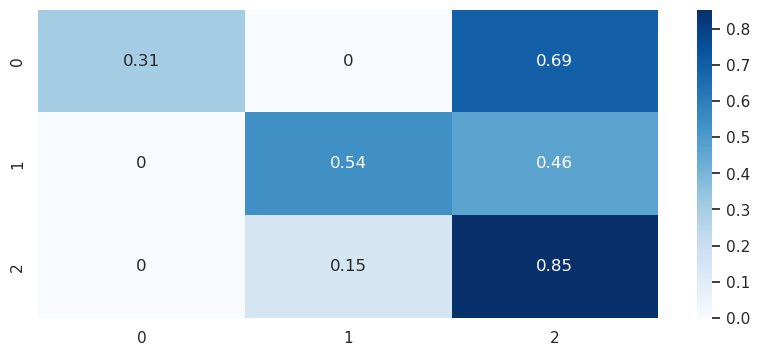

In [32]:
final_cf_matrix = np.zeros((len(CLASS),len(CLASS)))
for arr in cf_matrix_list:
    final_cf_matrix += arr
sns.heatmap(final_cf_matrix / final_cf_matrix.sum(axis=1)[:,None], 
            cmap='Blues',
            annot=True
           )
plt.show()

In [33]:
print(np.trace(final_cf_matrix)/np.sum(final_cf_matrix))
final_cf_matrix

0.7140115163147792


array([[ 26.,   0.,  59.],
       [  0.,  44.,  38.],
       [  0.,  52., 302.]])

In [34]:
cf_matrix_list

[array([[ 26,   0,  59],
        [  0,   0,   8],
        [  0,   0, 217]]),
 array([[ 0,  0,  0],
        [ 0, 44, 30],
        [ 0, 52, 85]])]

In [35]:
final_cf_matrix.sum(axis=0)[None,:]

array([[ 26.,  96., 399.]])